In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go

In [2]:
train_df = pd.read_csv('mnist_train.csv')
test_df = pd.read_csv('mnist_test.csv')

In [3]:
train_df.shape

(60000, 785)

## **Label-ների բաշխումը train և test տվյալների համար**

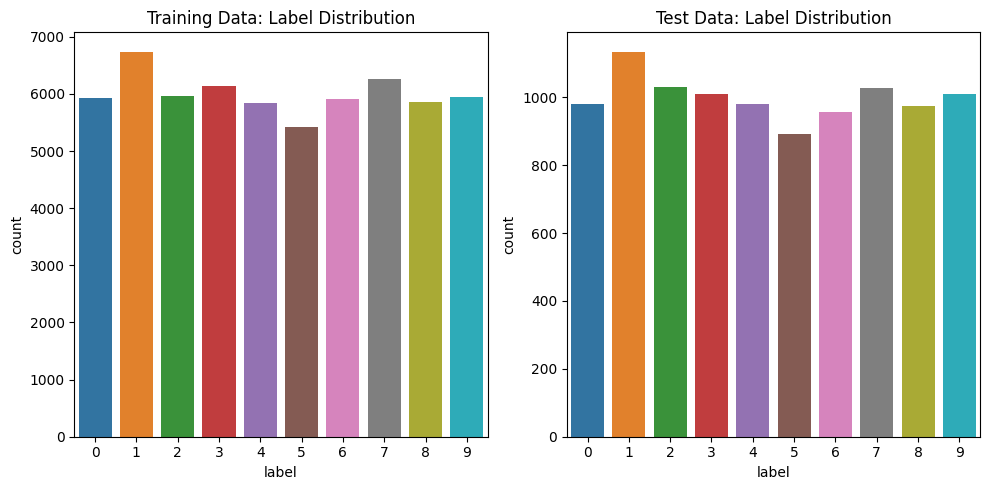

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='label', data=train_df)
plt.title('Training Data: Label Distribution')

plt.subplot(1, 2, 2)
sns.countplot(x='label', data=test_df)
plt.title('Test Data: Label Distribution')
plt.tight_layout()
plt.show()


In [5]:
# Extract labels and pixel data
labels_train = train_df.iloc[:, 0].values
pixels_train = train_df.iloc[:, 1:].values

# Extract labels and pixel data
labels_test = test_df.iloc[:, 0].values
pixels_test = test_df.iloc[:, 1:].values


In [6]:
pixels_train_scaled = pixels_train/255

pixels_test_scaled = pixels_test/255

In [7]:
pca = PCA(n_components=3)  

pixels_train_pca = pca.fit_transform(pixels_train_scaled)

pixels_test_pca = pca.transform(pixels_test_scaled)

gmm_models = {}

## **Վիզուալիզացիա GMM-ից առաջ**

In [62]:
import plotly.graph_objs as go

trace = go.Scatter3d(
    x=pixels_train_pca[:, 0],
    y=pixels_train_pca[:, 1],
    z=pixels_train_pca[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        color=labels_train,
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(title='Label')
    )
)

layout = go.Layout(
    title='3D PCA Visualization of MNIST Image Data',
    scene=dict(
        xaxis=dict(title='1'),
        yaxis=dict(title='2'),
        zaxis=dict(title='3')
    )
)

fig = go.Figure(data=[trace], layout=layout)
fig.show()


### *Մենք կգործարկենք GMM տարբեր PCA բաղադրիչներով(component-ներով) և GMM բաղադրիչներով(component-ներով), որպեսզի տեսնենք, թե որ համակցությունն է տալիս լավագույն արդյունքը թեստի տվյալների վրա:*

In [11]:
pca_components = [50, 100, 150]
gmm_components = [3, 5, 10, 15]
results = {}

for pca_comp in pca_components:
    # PCA
    pca = PCA(n_components=pca_comp)
    pixels_train_pca = pca.fit_transform(pixels_train_scaled)
    pixels_test_pca = pca.transform(pixels_test_scaled)
    
    pca_results = {}
    
    for gmm_comp in gmm_components:
        gmm_models = {}
        
        for digit in train_df['label'].unique():
            pixels_train_digit = pixels_train_pca[train_df['label'] == digit]
            gmm = GaussianMixture(n_components=gmm_comp, random_state=42)
            gmm.fit(pixels_train_digit)
            gmm_models[digit] = gmm
        
        predicted_labels = []
        
        for sample, true_label in zip(pixels_test_pca, test_df['label']):
            best_digit = None
            best_likelihood = float('-inf')
            
            for digit, gmm in gmm_models.items():
                likelihood = gmm.score([sample])
                if likelihood > best_likelihood:
                    best_likelihood = likelihood
                    best_digit = digit
            
            predicted_labels.append(best_digit)
        
     
        predicted_labels = np.array(predicted_labels)
        
      
        accuracy = np.mean(predicted_labels == test_df['label'])
        
        
        pca_results[gmm_comp] = accuracy
    
   
    results[pca_comp] = pca_results


for pca_comp, pca_result in results.items():
    for gmm_comp, accuracy in pca_result.items():
        print(f"For PCA n_components={pca_comp} and GMM n_components={gmm_comp}, Accuracy: {accuracy}")

/opt/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning:

Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



For PCA n_components=50 and GMM n_components=3, Accuracy: 0.9698
For PCA n_components=50 and GMM n_components=5, Accuracy: 0.9724
For PCA n_components=50 and GMM n_components=10, Accuracy: 0.9771
For PCA n_components=50 and GMM n_components=15, Accuracy: 0.9783
For PCA n_components=100 and GMM n_components=3, Accuracy: 0.9583
For PCA n_components=100 and GMM n_components=5, Accuracy: 0.9627
For PCA n_components=100 and GMM n_components=10, Accuracy: 0.9648
For PCA n_components=100 and GMM n_components=15, Accuracy: 0.9605
For PCA n_components=150 and GMM n_components=3, Accuracy: 0.9408
For PCA n_components=150 and GMM n_components=5, Accuracy: 0.9516
For PCA n_components=150 and GMM n_components=10, Accuracy: 0.9513
For PCA n_components=150 and GMM n_components=15, Accuracy: 0.9467


In [41]:
data = {
    'PCA_n_components': [50, 50, 50, 50, 100, 100, 100, 100, 150, 150, 150, 150],
    'GMM_n_components': [3, 5, 10, 15, 3, 5, 10, 15, 3, 5, 10, 15],
    'Accuracy': [0.9698, 0.9724, 0.9771, 0.9783, 0.9583, 0.9627, 0.9648, 0.9605, 0.9408, 0.9516, 0.9513, 0.9467]
}

df = pd.DataFrame(data)


table = go.Figure(data=[go.Table(
    header=dict(
        values=list(df.columns),
        fill_color='paleturquoise',
        align='left'
    ),
    cells=dict(
        values=[df[col] for col in df.columns],
        fill_color='lavender',
        align='left'
    )
)])

table.show()


### *Այս արդյունքից մենք տեսնում ենք, որ լավագույն արդյունքը ունենք, երբ PCA n_components=50 և GMM n_components=15*

In [51]:
pca = PCA(n_components=50,random_state=42)  
pixels_train_pca = pca.fit_transform(pixels_train_scaled)
pixels_test_pca = pca.transform(pixels_test_scaled)
gmm_models = {}

for digit in train_df['label'].unique():

    pixels_train_digit = pixels_train_pca[train_df['label'] == digit]   

    gmm = GaussianMixture(n_components=15, random_state=42)
    gmm.fit(pixels_train_digit)
    gmm_models[digit] = gmm

predicted_labels = []

for sample, true_label in zip(pixels_test_pca, test_df['label']):

    best_digit = None
    best_likelihood = float('-inf')  

    for digit, gmm in gmm_models.items():
        likelihood = gmm.score([sample]) 
        if likelihood > best_likelihood:
            best_likelihood = likelihood
            best_digit = digit
    predicted_labels.append(best_digit)
predicted_labels = np.array(predicted_labels)
accuracy = np.mean(predicted_labels == test_df['label'])

In [55]:
accuracy

0.976

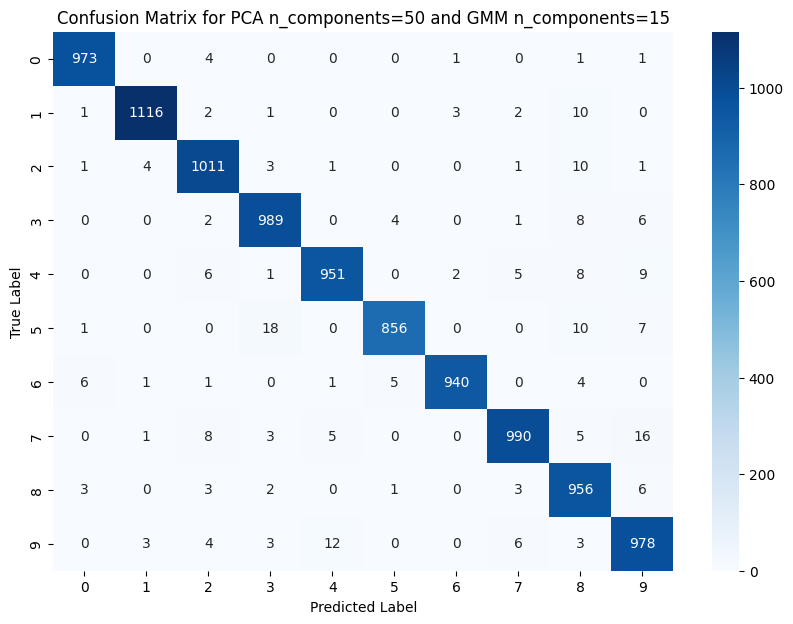

In [21]:
cm = confusion_matrix(test_df['label'], predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(list(train_df['label'].unique()))
            , yticklabels=sorted(list(train_df['label'].unique())))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for PCA n_components=50 and GMM n_components=15')
plt.show()

Ինչպես տեսնում ենք confusion matrix-ից, մոդելը լավ է աշխատում, քանի որ տեսնում ենք 1000-ին մոտ անկյունագծային արժեքներ, որոնք ցույց են տալիս ճիշտ կանխատեսումների թիվը: Ոչ անկյունագծային արժեքները շատ փոքր են, ինչը ցույց է տալիս, որ սխալ դասակարգումները նվազագույն են: Սա ցույց է տալիս, որ մոդելը հասնում է ցանկալի ճշգրտությանը:

## **Վիզուալիզացիա GMM-ից հելտո**

In [59]:
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd

pca_ = PCA(n_components=3)
pixels_test_pca = pca_.fit_transform(pixels_test_scaled)

df = pd.DataFrame(pixels_test_pca, columns=['PC1', 'PC2', 'PC3'])
df['Cluster'] = predicted_labels

scatter = go.Scatter3d(
    x=df['PC1'],
    y=df['PC2'],
    z=df['PC3'],
    mode='markers', 
    marker=dict(
        size=5,
        color=df['Cluster'],  
        colorscale='Viridis',
        colorbar=dict(title='Cluster'),
        opacity=0.8
    ),
    name='Data Points'
)

layout = go.Layout(
    title='3D PCA Visualization of MNIST Image Data',
    scene=dict(
        xaxis=dict(title='PC1'),
        yaxis=dict(title='PC2'),
        zaxis=dict(title='PC3')
    )
)

fig = go.Figure(data=[scatter], layout=layout)
fig.show()

